> __Purpose:__ This NB visualizes the results of the full study for ELEC573Net. Will be adding different feature engineerings here.

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42) 

from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from full_study_funcs import * 
from revamped_model_classes import *
from hyperparam_tuned_configs import *

import os
cwd = os.getcwd()
print("Current Working Directory: ", cwd)


Current Working Directory:  c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj


In [2]:
MODEL_STR = "ELEC573Net"
MY_CONFIG = ELEC573Net_config
SAVE_FIGS = False
NUM_MONTE_CARLO_RUNS = 10
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Train/test user split: 24/8
## Is this part of config now? The split number?
## No it is hardcoded below...
NUM_PRETRAIN_USERS = 24
NUM_FT_USERS = 8



In [3]:
expdef_df = load_expdef_gestures(feateng_method=MY_CONFIG["feature_engr"])

print(expdef_df.shape)
expdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [4]:
import json
# Load the fixed user splits
with open("24_8_user_splits.json", "r") as f:
    splits = json.load(f)
all_participants = splits["all_users"]
test_participants = splits["test_users"]


In [5]:
# Load the CLUSTERING RESULTS DATA
with open('C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\results\\clustering_models\\20250210_2032\\spectralFE80_ELEC573Net_agglo_merge_res.pkl', 'rb') as f:
    merge_log = pickle.load(f)
    intra_cluster_performance = pickle.load(f)
    cross_cluster_performance = pickle.load(f)
    nested_clus_model_dict = pickle.load(f)

print("Data has been loaded successfully!")

Data has been loaded successfully!


In [6]:
full_path = "C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\models\\20250211_2019"
print("Full Path:", full_path)
# Load the pretrained model
pretrained_generic_model = ELEC573Net(MY_CONFIG)
pretrained_generic_model.load_state_dict(torch.load(full_path+"\\pretrained_ELEC573Net_model.pth"))

Full Path: C:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\models\20250211_2019


<All keys matched successfully>

## One-shot training (local+FT)

In [7]:
lst_of_res_dicts_oneshot = [0]*NUM_MONTE_CARLO_RUNS
for i in range(NUM_MONTE_CARLO_RUNS):

    # Prepare data
    ## Unknown determenism / stochasticity...
    ## Some randomness from the 8/2 and 3/7 splits, namely which gestures get included...
    data_splits = prepare_data(
        expdef_df, 'feature', 'Gesture_Encoded', 
        all_participants, test_participants, 
        training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
    )

    # Fit LabelEncoder once on all participant IDs for consistency
    all_participant_ids = data_splits['train']['participant_ids'] + data_splits['intra_subject_test']['participant_ids']
    label_encoder = LabelEncoder()
    label_encoder.fit(all_participant_ids)

    # Process train and test sets
    train_df = process_split(data_splits, 'train', label_encoder)
    test_df = process_split(data_splits, 'intra_subject_test', label_encoder)
    data_dfs_dict = {'train':train_df, 'test':test_df}

    # Prepare data
    one_trial_data_splits = prepare_data(
        expdef_df, 'feature', 'Gesture_Encoded', 
        all_participants, test_participants, 
        training_trials_per_gesture=1, finetuning_trials_per_gesture=1,
    )
    #five_trial_data_splits = prepare_data(
    #    expdef_df, 'feature', 'Gesture_Encoded', 
    #    all_participants, test_participants, 
    #    training_trials_per_gesture=5, finetuning_trials_per_gesture=5,
    #)

    # data_dict_1_1
    lst_of_res_dicts_oneshot[i] = full_comparison_run(one_trial_data_splits, one_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                            nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')


PID P010, 1/8
Epoch 00019: reducing learning rate of group 0 to 1.0000e-06.
Cluster 34 had the highest accuracy (0.3)
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
PID P102, 2/8
Cluster 41 had the highest accuracy (0.4)
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
PID P104, 3/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Cluster 38 had the highest accuracy (0.7)
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
PID P108, 4/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Cluster 8 had the highest accuracy (0.6)
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
PID P121, 5/8
Cluster 41 had the highest accuracy (0.8)
PID P123, 6/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Cluster 8 had the highest accuracy (0.1)
PID P124, 7/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Cluster 38 had the highest accuracy (0.8)
Epoch 00006: reducing learning rate of group 0 to 1.

In [8]:
data_dict_1_1 = {}    
data_dict_1_1['local_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_1_1['centralized_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_1_1['ft_centralized_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_1_1['pretrained_cluster_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_1_1['ft_cluster_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)

for idx, res_dict in enumerate(lst_of_res_dicts_oneshot):
    data_dict_1_1['local_acc_data'] += np.array(res_dict['local_acc_data'])
    data_dict_1_1['centralized_acc_data'] += np.array(res_dict['centralized_acc_data'])
    data_dict_1_1['ft_centralized_acc_data'] += np.array(res_dict['ft_centralized_acc_data'])
    data_dict_1_1['pretrained_cluster_acc_data'] += np.array(res_dict['pretrained_cluster_acc_data'])
    data_dict_1_1['ft_cluster_acc_data'] += np.array(res_dict['ft_cluster_acc_data'])

data_dict_1_1['local_acc_data'] /= (idx+1)
data_dict_1_1['centralized_acc_data'] /= (idx+1)
data_dict_1_1['ft_centralized_acc_data'] /= (idx+1)
data_dict_1_1['pretrained_cluster_acc_data'] /= (idx+1)
data_dict_1_1['ft_cluster_acc_data'] /= (idx+1)

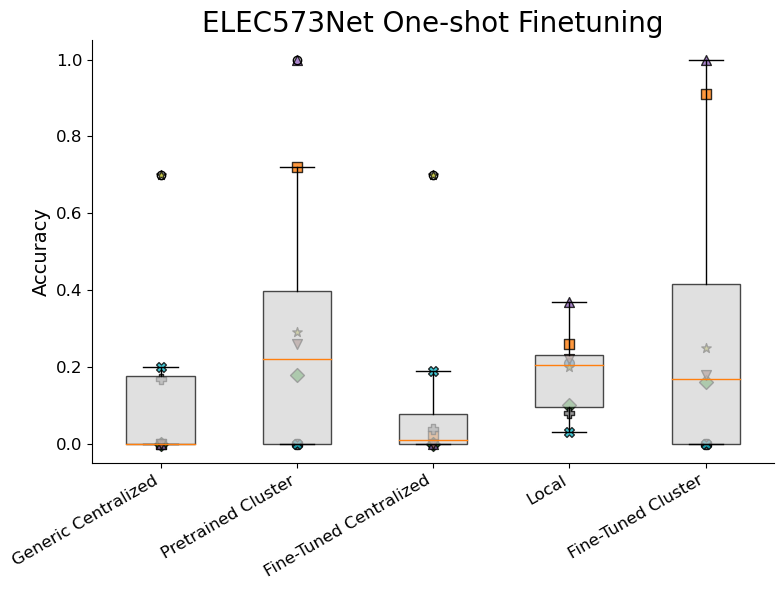

In [9]:
plot_model_acc_boxplots(data_dict_1_1, my_title=f"{MODEL_STR} One-shot Finetuning", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT")

## Few-shot (5 shot) trials for training (local+FT)

In [10]:
lst_of_res_dicts_fiveshot = [0]*NUM_MONTE_CARLO_RUNS
for i in range(NUM_MONTE_CARLO_RUNS):

    # Prepare data
    ## Unknown determenism / stochasticity...
    ## Some randomness from the 8/2 and 3/7 splits, namely which gestures get included...
    data_splits = prepare_data(
        expdef_df, 'feature', 'Gesture_Encoded', 
        all_participants, test_participants, 
        training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
    )

    # Fit LabelEncoder once on all participant IDs for consistency
    all_participant_ids = data_splits['train']['participant_ids'] + data_splits['intra_subject_test']['participant_ids']
    label_encoder = LabelEncoder()
    label_encoder.fit(all_participant_ids)

    # Process train and test sets
    train_df = process_split(data_splits, 'train', label_encoder)
    test_df = process_split(data_splits, 'intra_subject_test', label_encoder)
    data_dfs_dict = {'train':train_df, 'test':test_df}

    # Prepare data
    #one_trial_data_splits = prepare_data(
    #    expdef_df, 'feature', 'Gesture_Encoded', 
    #    all_participants, test_participants, 
    #    training_trials_per_gesture=1, finetuning_trials_per_gesture=1,
    #)
    five_trial_data_splits = prepare_data(
        expdef_df, 'feature', 'Gesture_Encoded', 
        all_participants, test_participants, 
        training_trials_per_gesture=5, finetuning_trials_per_gesture=5,
    )

    # data_dict_5_5
    lst_of_res_dicts_fiveshot[i] = full_comparison_run(five_trial_data_splits, five_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                            nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')


PID P010, 1/8
Epoch 00007: reducing learning rate of group 0 to 1.0000e-06.
Cluster 34 had the highest accuracy (0.22)
Epoch 00008: reducing learning rate of group 0 to 1.0000e-06.
PID P102, 2/8
Cluster 41 had the highest accuracy (0.64)
Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
PID P104, 3/8
Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Cluster 38 had the highest accuracy (0.66)
Epoch 00014: reducing learning rate of group 0 to 1.0000e-06.
PID P108, 4/8
Epoch 00008: reducing learning rate of group 0 to 1.0000e-06.
Cluster 8 had the highest accuracy (0.48)
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
PID P121, 5/8
Epoch 00016: reducing learning rate of group 0 to 1.0000e-06.
Cluster 41 had the highest accuracy (0.8)
Epoch 00016: reducing learning rate of group 0 to 1.0000e-06.
PID P123, 6/8
Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Cluster 36 had the highest accuracy (0.12)
PID P124, 7/8
Epoch 00007: reducing lear

In [11]:
data_dict_5_5 = {}    
data_dict_5_5['local_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_5_5['centralized_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_5_5['ft_centralized_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_5_5['pretrained_cluster_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_5_5['ft_cluster_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)

for idx, res_dict in enumerate(lst_of_res_dicts_fiveshot):
    data_dict_5_5['local_acc_data'] += np.array(res_dict['local_acc_data'])
    data_dict_5_5['centralized_acc_data'] += np.array(res_dict['centralized_acc_data'])
    data_dict_5_5['ft_centralized_acc_data'] += np.array(res_dict['ft_centralized_acc_data'])
    data_dict_5_5['pretrained_cluster_acc_data'] += np.array(res_dict['pretrained_cluster_acc_data'])
    data_dict_5_5['ft_cluster_acc_data'] += np.array(res_dict['ft_cluster_acc_data'])

data_dict_5_5['local_acc_data'] /= (idx+1)
data_dict_5_5['centralized_acc_data'] /= (idx+1)
data_dict_5_5['ft_centralized_acc_data'] /= (idx+1)
data_dict_5_5['pretrained_cluster_acc_data'] /= (idx+1)
data_dict_5_5['ft_cluster_acc_data'] /= (idx+1)

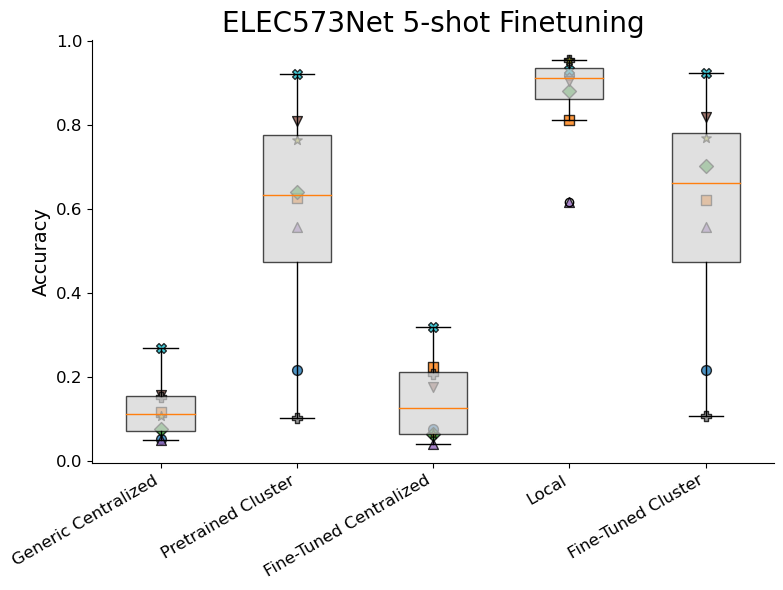

In [12]:
plot_model_acc_boxplots(data_dict_5_5, my_title=f"{MODEL_STR} 5-shot Finetuning", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_5TA_5TT")


In [13]:
data_dict_5_5.keys()

dict_keys(['local_acc_data', 'centralized_acc_data', 'ft_centralized_acc_data', 'pretrained_cluster_acc_data', 'ft_cluster_acc_data'])

In [14]:
data_dict_5_5['local_acc_data']

array([0.91800004, 0.812     , 0.88      , 0.61600006, 0.90599996,
       0.956     , 0.954     , 0.93      ], dtype=float32)

In [15]:
data_dict_5_5['centralized_acc_data']

array([0.052     , 0.116     , 0.07600001, 0.05      , 0.15599999,
       0.15200001, 0.10600001, 0.268     ], dtype=float32)

In [16]:
data_dict_5_5['ft_centralized_acc_data']

array([0.076, 0.224, 0.064, 0.04 , 0.176, 0.206, 0.064, 0.318],
      dtype=float32)

## Testing the Generic Model
> On its own training data (it was trained on train, tested on intra_test (same subjects as train), and also tested but not evaluated wrt cross_test)

In [17]:
model_type = "ELEC573Net"
sequence_length = 1  # Not sure what this should be here actually lol
time_steps = None
bs = MY_CONFIG["batch_size"]

In [18]:
unique_gestures = np.unique(data_splits['train']['labels'])
#num_classes = len(unique_gestures)
#input_dim = data_splits['train']['feature'].shape[1]

train_pids = data_splits['train']['participant_ids']  # THIS IS IN ORDER! NOT SHUFFLED!!
intra_pids = data_splits['intra_subject_test']['participant_ids']
cross_pids = data_splits['cross_subject_test']['participant_ids']

my_gesture_dataset = select_dataset_class(model_type)

train_dataset = my_gesture_dataset(
    data_splits['train']['feature'], 
    data_splits['train']['labels'], 
    sl=sequence_length, 
    ts=time_steps)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True) #, drop_last=True)

# INTRA SUBJECT (480)
intra_test_dataset = my_gesture_dataset(
    data_splits['intra_subject_test']['feature'], 
    data_splits['intra_subject_test']['labels'], 
    sl=sequence_length, 
    ts=time_steps)
# Shuffle doesn't matter for testing
intra_test_loader = DataLoader(intra_test_dataset, batch_size=bs, shuffle=False) #, drop_last=True)

# CROSS SUBJECT (560)
## Wait shouldn't I have 2 cross datasets? Are these the withheld users??
## I should have finetuning and withheld right? Presumably cross_test is withheld?
cross_test_dataset = my_gesture_dataset(
    data_splits['cross_subject_test']['feature'], 
    data_splits['cross_subject_test']['labels'], 
    sl=sequence_length, 
    ts=time_steps)
# Shuffle doesn't matter for testing
cross_test_loader = DataLoader(cross_test_dataset, batch_size=bs, shuffle=False) #, drop_last=True)

In [19]:
#'loss': total_loss / len(dataloader),
#'accuracy': np.mean(np.array(all_preds) == np.array(all_labels)),
#'predictions': all_preds,
#'true_labels': all_labels

train_eval = evaluate_model(pretrained_generic_model, train_loader)
print(train_eval['accuracy'])

0.9166666666666666


In [20]:
intra_eval = evaluate_model(pretrained_generic_model, intra_test_loader)
print(intra_eval['accuracy'])

0.9020833333333333


In [21]:
cross_eval = evaluate_model(pretrained_generic_model, cross_test_loader)
print(cross_eval['accuracy'])

0.11785714285714285


> Now looking at the novel finetuning participants specifically (one trial of data)

In [22]:
finetuning_datasplits = one_trial_data_splits
config = MY_CONFIG

In [23]:
train_pids = np.unique(finetuning_datasplits['train']['participant_ids'])

novel_participant_ft_data = finetuning_datasplits['novel_trainFT']
# novel "cross subject" is the same as novel intra (but needs to be separated according to PID first...)
novel_participant_test_data = finetuning_datasplits['cross_subject_test']
novel_pids = np.unique(finetuning_datasplits['novel_trainFT']['participant_ids'])

novel_pid_res_dict = {}
for pid_count, pid in enumerate(novel_pids):
    print(f"PID {pid}, {pid_count+1}/{len(novel_pids)}")
    novel_pid_res_dict[pid] = {}

    # Create the testloader by segmenting out this specific pid
    # Filter based on CURRENT participant ID: 
    indices = [i for i, datasplit_pid in enumerate(novel_participant_ft_data['participant_ids']) if datasplit_pid == pid]
    ############## Novel Participant Finetuning Dataset ##############
    ft_dataset = GestureDataset([novel_participant_ft_data['feature'][i] for i in indices], [novel_participant_ft_data['labels'][i] for i in indices])
    ft_loader = DataLoader(ft_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## Novel Participant Intra Testing Dataset ##############
    intra_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    intra_test_loader = DataLoader(intra_test_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## Novel Participant Cross Testing Dataset ##############
    # This code is testing on all the other novel participants... I don't think we care about that right now
    ## Idc but this will allow us to check cross perf. No real reason to remove...
    indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid != pid]
    cross_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    cross_test_loader = DataLoader(cross_test_dataset, batch_size=config["batch_size"], shuffle=True)

    # 2) Test the full pretrained (centralized) model
    generic_clus_res = evaluate_model(pretrained_generic_model, intra_test_loader)
    novel_pid_res_dict[pid]["centralized_acc"] = generic_clus_res["accuracy"]
    print(f"Pretrain generic acc: {generic_clus_res['accuracy']}")

    # 3) Test finetuned pretrained (centralized) model
    ft_centralized_model, _, _, _ = fine_tune_model(
        pretrained_generic_model, ft_loader, config, config['timestamp'], test_loader=intra_test_loader, pid=pid)
    ft_centralized_res = evaluate_model(ft_centralized_model, intra_test_loader)
    novel_pid_res_dict[pid]["ft_centralized_acc"] = ft_centralized_res["accuracy"]
    print(f"Pretrain FT acc: {ft_centralized_res['accuracy']}")

    print()

PID P010, 1/8
Pretrain generic acc: 0.4
Pretrain FT acc: 0.5

PID P102, 2/8
Pretrain generic acc: 0.1
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.0

PID P104, 3/8
Pretrain generic acc: 0.0
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.0

PID P108, 4/8
Pretrain generic acc: 0.0
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.0

PID P121, 5/8
Pretrain generic acc: 0.0
Pretrain FT acc: 0.0

PID P123, 6/8
Pretrain generic acc: 0.6
Pretrain FT acc: 0.5

PID P124, 7/8
Pretrain generic acc: 0.8
Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.7

PID P128, 8/8
Pretrain generic acc: 0.2
Pretrain FT acc: 0.2



We observe an extremely skewed performance, it does decent on P123 and P124, and worse than random chance on everyone else.  Also FTing doesn't seem to improve performance, in some cases makes it worse...

> Now looking at the novel finetuning participants specifically (five trials of data)

In [24]:
finetuning_datasplits = five_trial_data_splits
config = MY_CONFIG

In [25]:
train_pids = np.unique(finetuning_datasplits['train']['participant_ids'])

novel_participant_ft_data = finetuning_datasplits['novel_trainFT']
# novel "cross subject" is the same as novel intra (but needs to be separated according to PID first...)
novel_participant_test_data = finetuning_datasplits['cross_subject_test']
novel_pids = np.unique(finetuning_datasplits['novel_trainFT']['participant_ids'])

novel_pid_res_dict = {}
for pid_count, pid in enumerate(novel_pids):
    print(f"PID {pid}, {pid_count+1}/{len(novel_pids)}")
    novel_pid_res_dict[pid] = {}

    # Create the testloader by segmenting out this specific pid
    # Filter based on CURRENT participant ID: 
    indices = [i for i, datasplit_pid in enumerate(novel_participant_ft_data['participant_ids']) if datasplit_pid == pid]
    ############## Novel Participant Finetuning Dataset ##############
    ft_dataset = GestureDataset([novel_participant_ft_data['feature'][i] for i in indices], [novel_participant_ft_data['labels'][i] for i in indices])
    ft_loader = DataLoader(ft_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## Novel Participant Intra Testing Dataset ##############
    intra_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    intra_test_loader = DataLoader(intra_test_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## Novel Participant Cross Testing Dataset ##############
    # This code is testing on all the other novel participants... I don't think we care about that right now
    ## Idc but this will allow us to check cross perf. No real reason to remove...
    indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid != pid]
    cross_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    cross_test_loader = DataLoader(cross_test_dataset, batch_size=config["batch_size"], shuffle=True)

    # 2) Test the full pretrained (centralized) model
    generic_clus_res = evaluate_model(pretrained_generic_model, intra_test_loader)
    novel_pid_res_dict[pid]["centralized_acc"] = generic_clus_res["accuracy"]
    print(f"Pretrain generic acc: {generic_clus_res['accuracy']}")

    # 3) Test finetuned pretrained (centralized) model
    ft_centralized_model, _, _, _ = fine_tune_model(
        pretrained_generic_model, ft_loader, config, config['timestamp'], test_loader=intra_test_loader, pid=pid)
    ft_centralized_res = evaluate_model(ft_centralized_model, intra_test_loader)
    novel_pid_res_dict[pid]["ft_centralized_acc"] = ft_centralized_res["accuracy"]
    print(f"Pretrain FT acc: {ft_centralized_res['accuracy']}")

    print()

PID P010, 1/8
Pretrain generic acc: 0.1
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.1

PID P102, 2/8
Pretrain generic acc: 0.16
Epoch 00016: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.26

PID P104, 3/8
Pretrain generic acc: 0.04
Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.04

PID P108, 4/8
Pretrain generic acc: 0.04
Epoch 00007: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.02

PID P121, 5/8
Pretrain generic acc: 0.14
Pretrain FT acc: 0.34

PID P123, 6/8
Pretrain generic acc: 0.12
Epoch 00008: reducing learning rate of group 0 to 1.0000e-06.
Pretrain FT acc: 0.2

PID P124, 7/8
Pretrain generic acc: 0.1
Pretrain FT acc: 0.04

PID P128, 8/8
Pretrain generic acc: 0.3
Pretrain FT acc: 0.3

